In [1]:
import torch
import torch.nn as nn
import matplotlib.pylab as plt

# 1. Visualization of different activation functions:

In [2]:
# Define a dictionary of activation functions
activation_dict = {
    "ReLU": nn.ReLU(),
    "LeakyReLU": nn.LeakyReLU(negative_slope=0.1),
    "ELU": nn.ELU(),
    "Sigmoid": nn.Sigmoid(),
    "SiLU": nn.SiLU(),
    "GELU": nn.GELU(),
}

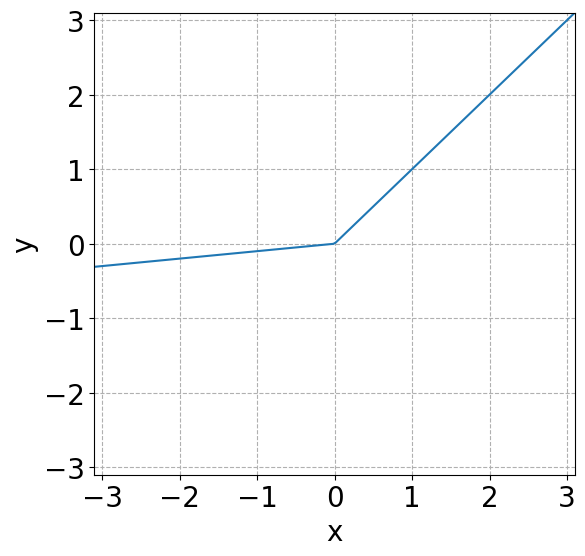

In [3]:
# Choose from "ReLU", "LeakyReLU", "ELU", "Sigmoid", "SiLU", "GELU", etc.:
activation_name = "ReLU"
activation_name = "LeakyReLU"  
# activation_name = "ELU" 
# activation_name = "Sigmoid" 
# activation_name = "SiLU" 
# activation_name = "GELU" 
# Obtain the 
lim = 3
x_points = torch.linspace(-lim-0.1, lim+0.1, 200)
activation_fun = activation_dict[activation_name]  # Obtain the actual activation function
y_points = activation_fun(x_points)

# Plotting the activation function:
fontsize = 20
plt.figure(figsize=(6.2,6))
plt.plot(x_points.numpy(), y_points.numpy())
plt.xlim([-lim-0.1,lim+0.1])
plt.ylim([-lim-0.1,lim+0.1])
plt.xticks(torch.arange(-lim,lim+1,1))
plt.yticks(torch.arange(-lim,lim+1,1))
plt.xlabel("x", fontsize=fontsize)
plt.ylabel("y", fontsize=fontsize)
plt.grid(linestyle = '--')
plt.tick_params(labelsize=fontsize)
plt.show()

# 2. Learning by maximum likelihood:

## 2.0 Preparing dataset:

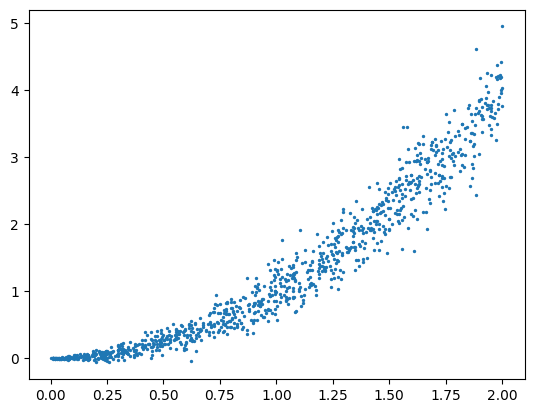

In [4]:
n_examples = 5000
n_train = int(n_examples * 0.8)
feature_size = 1
X = torch.rand(n_examples, feature_size) * 2
Y = (X ** 2).sum(-1, keepdim=True) + torch.randn(n_examples, feature_size) * X * 0.2 # The y noise is larger the larger the x
X_train, Y_train = X[:n_train], Y[:n_train]
X_test, Y_test = X[n_train:], Y[n_train:]
plt.scatter(X_test, Y_test, s=2)
plt.show()

## 2.1 Learning with MSE:

In [5]:
# Prepare the neural network:
class MLP_mu(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        # Constructing a 3-layer network:
        self.layer_1 = nn.Linear(input_size, hidden_size)
        self.layer_2 = nn.Linear(hidden_size, hidden_size)
        self.layer_3 = nn.Linear(hidden_size, output_size)
        self.activation_fun = nn.ELU()

    def forward(self, x):
        x = activation_fun(self.layer_1(x))
        x = activation_fun(self.layer_2(x))
        x = self.layer_3(x)  # Typically have linear activation at the last layer
        return x

def plot(X, Y, model):
    fontsize = 14
    plt.figure(figsize=(5,4))
    plt.scatter(X, Y, s=2, label="test data")
    X_points = torch.linspace(0,2,200)[:,None]  # X_points has shape of [200, 1]. The [:,None] adds a dimension at the second axis.
    pred = model(X_points)
    if type(pred) is not tuple:
        pred_mean = pred.detach()
        plt.plot(X_points.flatten(), pred_mean.flatten(), c="r", label="prediction")
    else:
        assert len(pred) == 2
        mu_pred, sigma_pred = pred
        mu_pred, sigma_pred = mu_pred.detach(), sigma_pred.detach()
        plt.plot(X_points.flatten(), mu_pred.flatten(), c="r", label="prediction")
        plt.fill_between(
            X_points.flatten(), (mu_pred-sigma_pred).flatten(), (mu_pred+sigma_pred).flatten(),
            color="r", alpha=0.3, label="sigma",
        )
    plt.legend(fontsize=fontsize)
    plt.xlabel("x", fontsize=fontsize)
    plt.ylabel("y", fontsize=fontsize)
    plt.tick_params(labelsize=fontsize)
    plt.show()

Step 0   loss: 3.5693


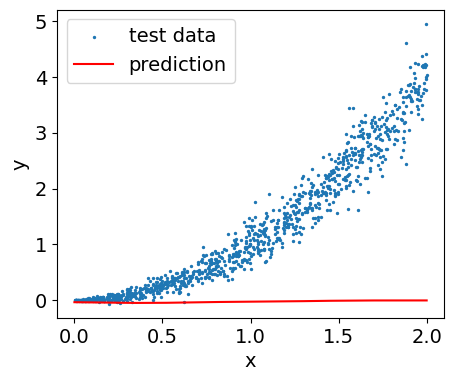

Step 50   loss: 0.2867


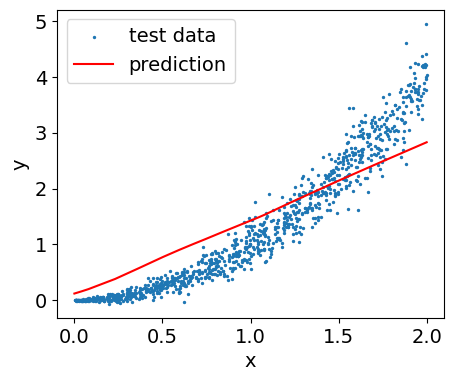

Step 100   loss: 0.0809


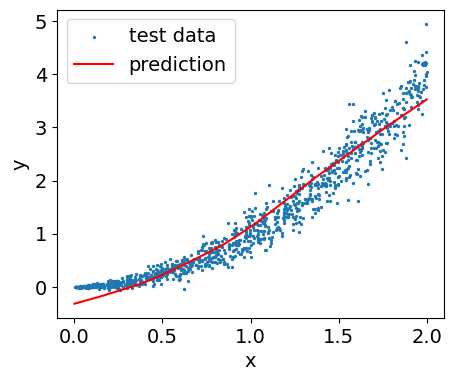

Step 150   loss: 0.0619


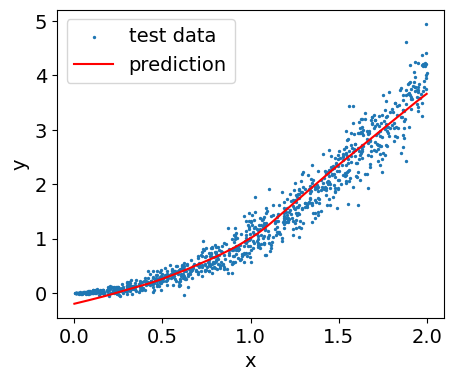

Step 200   loss: 0.0566


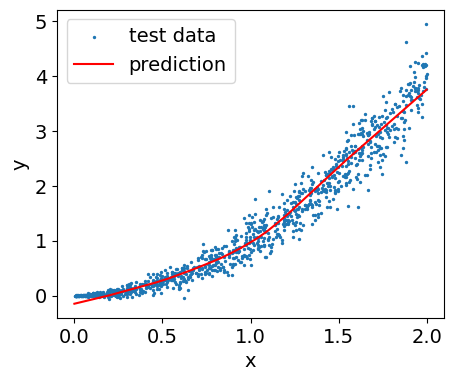

Step 250   loss: 0.0548


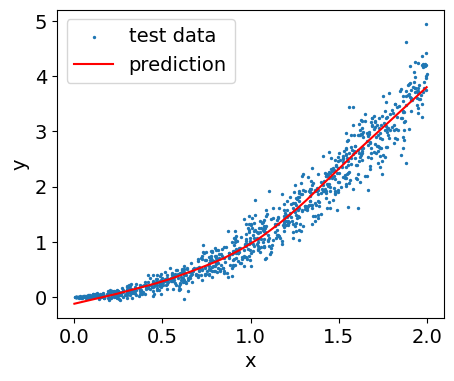

Step 300   loss: 0.0537


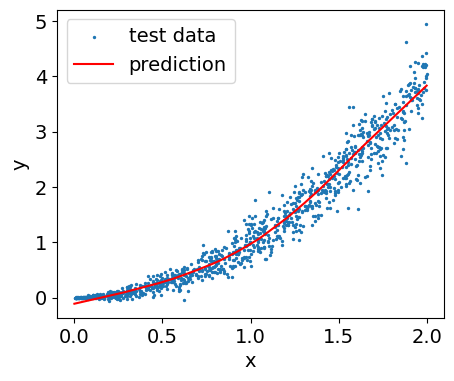

Step 350   loss: 0.0531


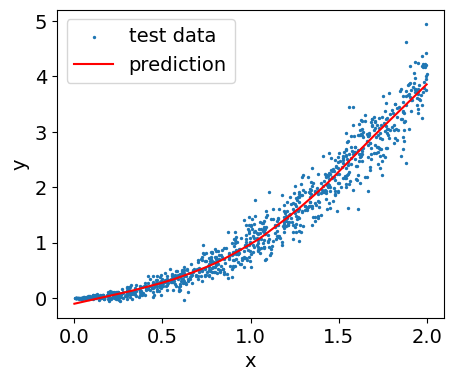

Step 400   loss: 0.0528


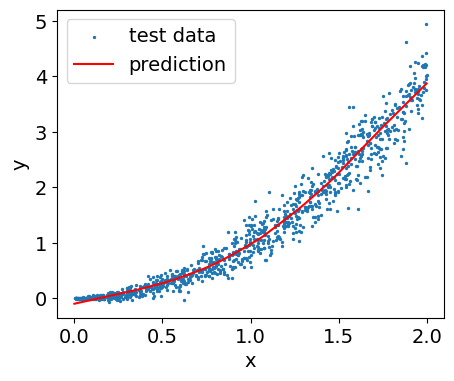

Step 450   loss: 0.0526


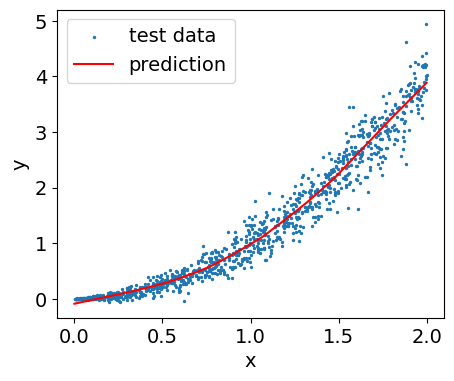

Step 500   loss: 0.0524


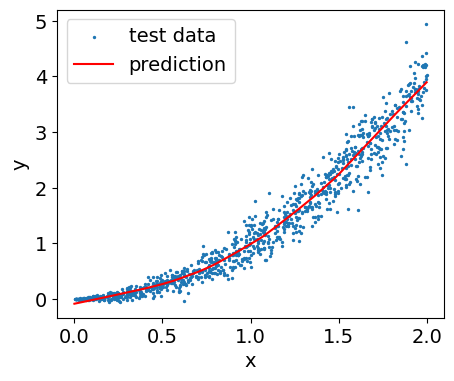

In [6]:
# Initialize model and optimizer:
model = MLP_mu(
    input_size=feature_size,
    hidden_size=64,
    output_size=1,
)
epochs = 500
lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# Learning with gradient descent:
for k in range(epochs+1):
    optimizer.zero_grad() # Required, to clear the gradient in previous step. Otherwise the gradient will accumulate.
    pred = model(X_train)
    # MSE loss:
    loss = ((pred - Y_train) ** 2).mean()
    loss.backward()
    optimizer.step()
    if k % 50 == 0:
        print(f"Step {k}   loss: {loss.item():.4f}")
        plot(X_test, Y_test, model)

## 2.2 Learning uncertainty:

In [7]:
# Prepare the neural network:
class MLP_mu_sigma(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        # Constructing a 3-layer network:
        self.layer_1 = nn.Linear(input_size, hidden_size)
        self.layer_2 = nn.Linear(hidden_size, hidden_size)
        self.layer_3_mu = nn.Linear(hidden_size, output_size)
        self.layer_3_log_sigma = nn.Linear(hidden_size, output_size)
        self.activation_fun = nn.ELU()

    def forward(self, x):
        x = activation_fun(self.layer_1(x))
        x = activation_fun(self.layer_2(x))
        x_mu = self.layer_3_mu(x)
        # Here we use the neural network to represent log_sigma, so its sigma = exp(log_sigma) will always be positive:
        x_sigma = torch.exp(self.layer_3_log_sigma(x))
        return x_mu, x_sigma

Step 0   loss: 1.8022


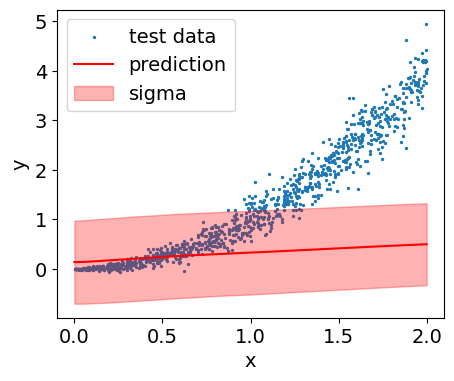

Step 3000   loss: -1.4175


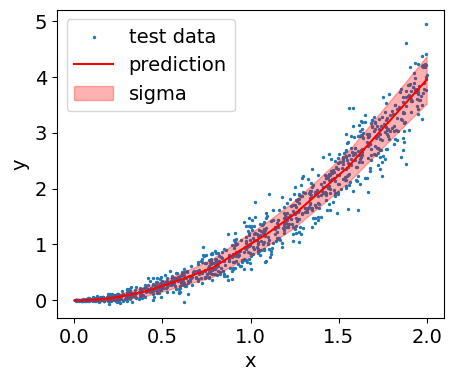

Step 6000   loss: -1.4194


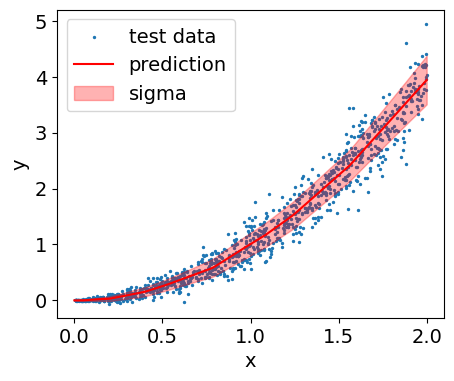

Step 9000   loss: -1.4226


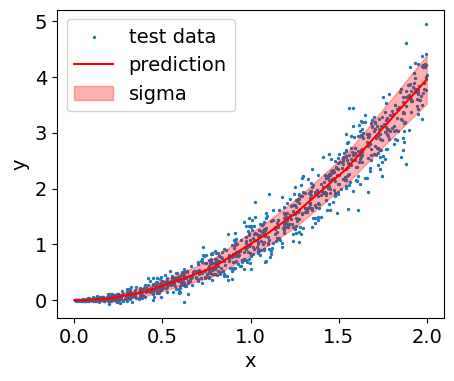

Step 12000   loss: -1.4044


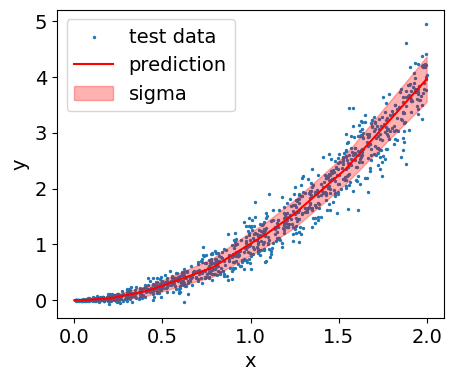

Step 15000   loss: -1.4139


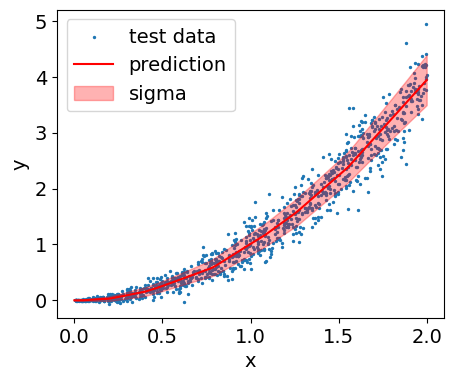

Step 18000   loss: -1.4157


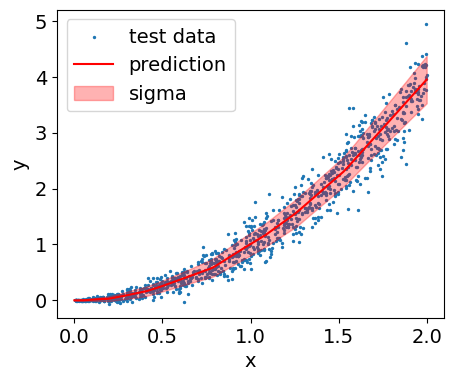

Step 21000   loss: -1.4223


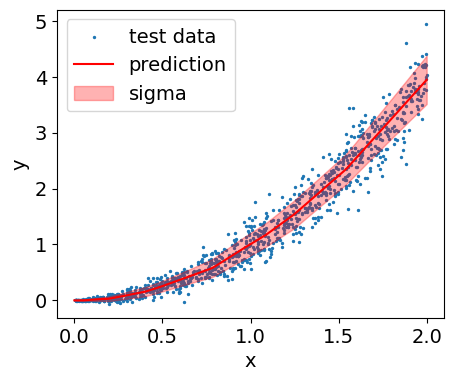

Step 24000   loss: -1.4175


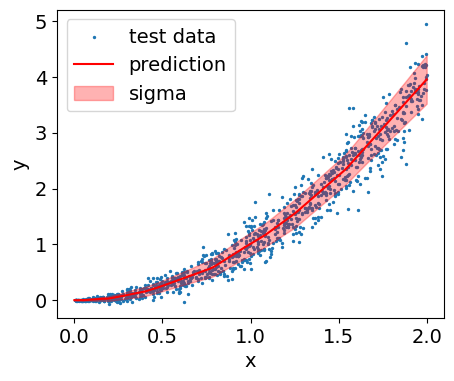

Step 27000   loss: -1.4145


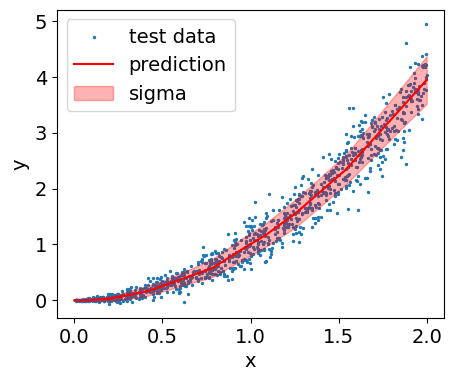

Step 30000   loss: -1.4239


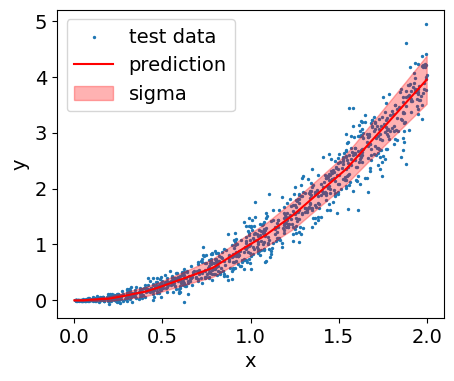

In [8]:
# Learning with gradient descent:
epochs = 30000
lr = 1e-3
model = MLP_mu_sigma(
    input_size=feature_size,
    hidden_size=64,
    output_size=1,
)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
for k in range(epochs+1):
    optimizer.zero_grad() # Required, to clear the gradient in previous step. Otherwise the gradient will accumulate.
    mu_pred, sigma_pred = model(X_train)
    # MSE loss:
    loss = ((mu_pred - Y_train) ** 2 / (2 * sigma_pred**2)  + torch.log(sigma_pred)).mean()
    loss.backward()
    optimizer.step()
    if k % 3000 == 0:
        print(f"Step {k}   loss: {loss.item():.4f}")
        plot(X_test, Y_test, model)